*Note to self: Code from /Summer2014TSAnalysisTime/CCA_Figures.R*

In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library("dplyr", lib.loc="/Library/Frameworks/R.framework/Versions/3.0/Resources/library")
library(plyr)
library("vegan")

#Data loading and adjustment----
alldata<-read.table("/Users/juliambrown/Documents/6thYear/TimeSeries/Summer2014TSAnalysisTime/All_Integrated_Output.csv",sep=",",header=TRUE)
alldata$date<-as.Date(alldata$date, "%Y-%m-%d")
precip.esf<-read.table("esf.meanprecip.csv", sep=",",header=TRUE)
alldata<-join(alldata, precip.esf, by=c("Month","Year"))    #joined the precip data with all other data

##Exclusions:
# Remove October observations
alldata<-alldata[alldata$Month!=10,]
#alldata<-alldata[alldata$Month!=9,]
alldata<-alldata[alldata$Month!=3,]

#making a column of row labels:
alldata$name<-paste(alldata$lake,alldata$date,sep="_")
row.names(alldata)<-alldata$name
alldata$month.day<-alldata$Month+alldata$Day/32   #give each day in month a unique numeric
alldata$lake.year<-paste(alldata$lake, alldata$Year, sep="")
alldata$lake.year<-as.factor(alldata$lake.year)
alldata$Month<-as.factor(alldata$Month)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, desc, failwith, id, mutate, summarise, summarize

Loading required package: permute
Loading required package: lattice
This is vegan 2.2-0


In [6]:
%%R
lypch=c(19,17,1,2)
lycol=c("aquamarine4","aquamarine4","black","black")
mcol=c("red","orange","green","blue","purple")
mcol2=c("firebrick4","darkorange4","forestgreen","navyblue","purple4")
mpch=c(17,19)
ycol=c("red","black")
scl=3
###Adjustments### ----

alldata$logcyano<-log(1+alldata$cyano, 10)

alldata$logbin1.cyanos<-log(1+alldata$bin1.cyanos,10)
alldata$logbin2.cyanos<-log(1+alldata$bin2.cyanos,10)
alldata$logbin3.cyanos<-log(1+alldata$bin3.cyanos,10)
alldata$logbin4.cyanos<-log(1+alldata$bin4.cyanos,10)

alldata$logrlcp1<-log(1+alldata$rlcp1,10)
alldata$logrlcp2a<-log(1+alldata$rlcp2a,10)
alldata$logrlcp4<-log(1+alldata$rlcp4,10)


                    date lake Year Month Day  temp     do salinity conductivity
GL_2012-04-27 2012-04-27   GL 2012     4  27 10.50  2.900     1.00       1370.0
RL_2012-04-27 2012-04-27   RL 2012     4  27 10.00  2.580     1.00       1370.0
GL_2012-05-02 2012-05-02   GL 2012     5   2 11.65 10.285     0.95       1429.0
RL_2012-05-02 2012-05-02   RL 2012     5   2 11.85 10.355     1.00       1449.0
GL_2012-05-10 2012-05-10   GL 2012     5  10 14.35  8.905     1.00       1551.0
RL_2012-05-10 2012-05-10   RL 2012     5  10 13.90  8.855     1.00       1504.5
GL_2012-05-16 2012-05-16   GL 2012     5  16 17.30  9.515     1.00       1657.0
RL_2012-05-16 2012-05-16   RL 2012     5  16 17.30  9.365     1.00       1627.5
GL_2012-05-23 2012-05-23   GL 2012     5  23 19.90  9.225     1.00       1768.0
RL_2012-05-23 2012-05-23   RL 2012     5  23 19.60  9.000     0.95       1685.5
GL_2012-05-30 2012-05-30   GL 2012     5  30 22.15  7.980     1.00       1807.5
RL_2012-05-30 2012-05-30   RL 2012     5

In [8]:
%%R
# run this to normalize all measurements
alldata[,c("temp","do","pH","nitrate","nitrite","srp","chla","bac","vlp","cyano","TPCP")]<-scale(alldata[,c("temp","do","pH","nitrate","nitrite","srp","chla","bac","vlp","cyano","TPCP")], center=TRUE, scale=TRUE)

In [9]:
%%R

#pull out cyano normalized
ad.logcyano<-alldata[,c("logbin1.cyanos","logbin2.cyanos","logbin3.cyanos","logbin4.cyanos")]
ad.cyano<-alldata[,c("bin1.cyanos","bin2.cyanos","bin3.cyanos","bin4.cyanos")]
#pull out cyanophage types
ad.cyphage<-alldata[,c("rlcp1","rlcp2a","rlcp4")]
ad.logcyphage<-alldata[,c("logrlcp1","logrlcp2a","logrlcp4")]

#must remove zero rows first from data to use for odination ----
ad.logcyano$sum<-rowSums(ad.logcyano[,1:4])
ad.logcyanonz<-ad.logcyano[ad.logcyano$sum!=0,]
ad.logcyanonz$sum<-NULL

ad.logcyphage$sum<-rowSums(ad.logcyphage[,1:3])
ad.logcyphagenz<-ad.logcyphage[ad.logcyphage$sum!=0,]
ad.logcyphagenz$sum<-NULL

#Arrange the data files to use for constrained ordination analyses ----
cyano.cca.prep<-merge(ad.logcyanonz, alldata, by="row.names")
cyphage.cca.prep<-merge(ad.logcyphagenz, alldata, by="row.names")

In [12]:
%%R
row.names(cyano.cca.prep)<-cyano.cca.prep$Row.names
cyano.cca.prep1<-na.omit(cyano.cca.prep[,c("month.day","lake.year","logbin1.cyanos.x","logbin2.cyanos.x","logbin3.cyanos.x","logbin4.cyanos.x","TPCP","temp","nitrate","srp","nitrite","do","pH","bac","vlp","logrlcp1","logrlcp2a","logrlcp4")])
ad.lc.nz.nna<-cyano.cca.prep1[,c("logbin1.cyanos.x","logbin2.cyanos.x","logbin3.cyanos.x","logbin4.cyanos.x")]
colnames(ad.lc.nz.nna)<-c("Cyano1","Cyano2","Cyano3","Cyano4")
lcnznna.meta<-cyano.cca.prep1[,c("TPCP","temp","srp","nitrate","nitrite","do","pH","bac","vlp")] #"logrlcp1","logrlcp2a","logrlcp4")]

cyano.cca8<-cca(ad.lc.nz.nna~.,lcnznna.meta)
cyano.cca0<-cca(ad.lc.nz.nna~1,lcnznna.meta)

cyano.cca.ordistep<-ordistep(cyano.cca0, scope = formula(cyano.cca8), direction="forward",perm=499)
cyano.cca.ordistep
cyano.cca.ordistep<-cca(ad.lc.nz.nna~temp+pH+do+srp, data=lcnznna.meta)
anova(cyano.cca.ordistep)
anova(cyano.cca.ordistep, by="term", step=200)


Start: ad.lc.nz.nna ~ 1 

          Df    AIC       F Pr(>F)   
+ temp     1 27.332 13.5727  0.002 **
+ vlp      1 31.357  8.5904  0.002 **
+ do       1 32.159  7.6595  0.004 **
+ bac      1 33.888  5.7176  0.004 **
+ pH       1 36.260  3.1928  0.052 . 
+ nitrite  1 36.908  2.5307  0.084 . 
+ nitrate  1 37.635  1.8004  0.198   
+ srp      1 38.691  0.7646  0.534   
+ TPCP     1 39.250  0.2273  0.814   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Step: ad.lc.nz.nna ~ temp 

          Df    AIC      F Pr(>F)  
+ nitrite  1 25.411 3.8043  0.026 *
+ pH       1 25.371 3.8453  0.034 *
+ do       1 25.774 3.4353  0.038 *
+ srp      1 27.154 2.0645  0.124  
+ nitrate  1 28.177 1.0799  0.360  
+ TPCP     1 28.455 0.8170  0.482  
+ vlp      1 28.665 0.6204  0.576  
+ bac      1 28.699 0.5877  0.618  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Step: ad.lc.nz.nna ~ temp + nitrite 

          Df    AIC      F Pr(>F)  
+ pH       1 23.866 3.3249  0.0


Start: ad.lp.nz.nna ~ 1 

          Df     AIC       F Pr(>F)   
+ temp     1 -29.279 21.4597  0.002 **
+ do       1 -28.757 20.6756  0.002 **
+ pH       1 -21.993 11.4342  0.008 **
+ TPCP     1 -21.814 11.2109  0.008 **
+ vlp      1 -20.156  9.1958  0.024 * 
+ bac      1 -18.065  6.7753  0.050 * 
+ cyano    1 -17.299  5.9226  0.050 * 
+ srp      1 -14.932  3.3902  0.220   
+ nitrite  1 -12.605  1.0502  0.636   
+ nitrate  1 -12.335  0.7883  0.738   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Step: ad.lp.nz.nna ~ temp 

          Df     AIC       F Pr(>F)   
+ pH       1 -45.972 22.2406  0.002 **
+ TPCP     1 -45.045 20.8611  0.002 **
+ bac      1 -41.148 15.4161  0.008 **
+ vlp      1 -36.521  9.6368  0.014 * 
+ do       1 -35.590  8.5564  0.028 * 
+ srp      1 -30.695  3.2918  0.214   
+ nitrite  1 -28.456  1.1008  0.480   
+ cyano    1 -27.901  0.5774  0.648   
+ nitrate  1 -28.052  0.7186  0.674   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0

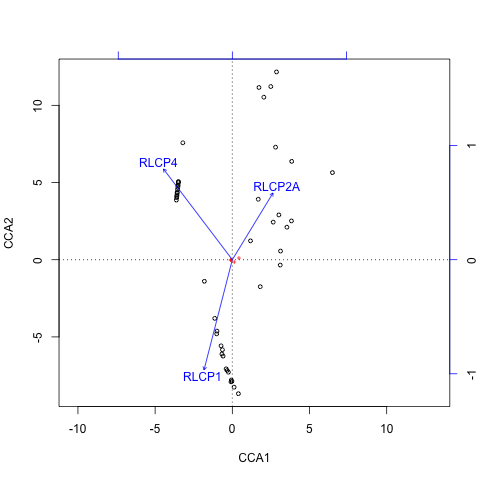

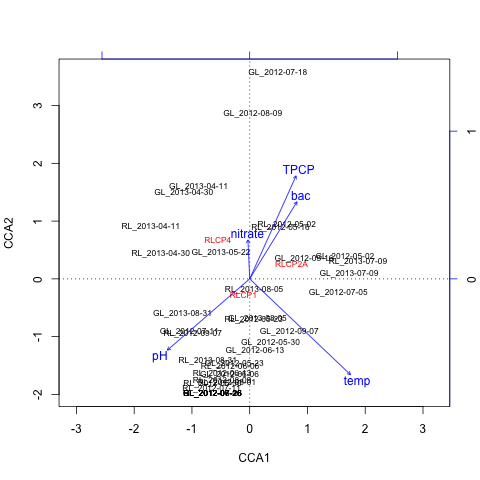

In [13]:
%%R
phage<-decostand(cyano.cca.prep[,c("logrlcp1","logrlcp2a","logrlcp4")], method="chi.square")
colnames(phage)<-c("RLCP1","RLCP2A","RLCP4")
cyano.cca4<-cca(ad.logcyanonz~RLCP1+RLCP2A+RLCP4, phage, na.action=na.omit)
cyano.cca4
anova(cyano.cca4)
anova(cyano.cca4, by="term", step=200)
ordiplot(cyano.cca4)

#Cyanophage:
row.names(cyphage.cca.prep)<-cyphage.cca.prep$Row.names
cyphage.cca.prep1<-na.omit(cyphage.cca.prep[,c("month.day","lake.year","logrlcp1.x","logrlcp2a.x","logrlcp4.x","TPCP","temp","nitrate","srp","nitrite","do","pH","bac","vlp","cyano","logbin1.cyanos","logbin2.cyanos","logbin3.cyanos","logbin4.cyanos")])

ad.lp.nz.nna<-cyphage.cca.prep1[,c("logrlcp1.x","logrlcp2a.x","logrlcp4.x")]

colnames(ad.lp.nz.nna)<-c("RLCP1","RLCP2A","RLCP4")
lpnznna.meta<-cyphage.cca.prep1[,c("TPCP","temp","nitrate","srp","nitrite","do","pH","bac","vlp","cyano")]  #"logbin1.cyanos","logbin2.cyanos","logbin3.cyanos","logbin4.cyanos")]

cyphage.cca0<-cca(ad.lp.nz.nna~1,lpnznna.meta)

cyphage.cca.all<-cca(ad.lp.nz.nna~.,lpnznna.meta)
cyphage.cca.ordistep<-ordistep(cyphage.cca0, scope=formula(cyphage.cca.all), direction="forward", perm=499)
cyphage.cca.ordistep
cyphage.cca.ordistep1<-cca(ad.lp.nz.nna~temp+pH+TPCP+bac+nitrate, lpnznna.meta, na.action=na.omit)
cyphage.cca.ordistep1
cyphage.ordistep.plot<-plot(cyphage.cca.ordistep1)

#permutation tests to assess significance:
anova(cyphage.cca.ordistep1)
anova(cyphage.cca.ordistep1, by="term", step=200)

anova(cyphage.cca.ordistep1, by="margin", perm=500)
anova(cyphage.cca.ordistep1, by="axis", perm=1000)

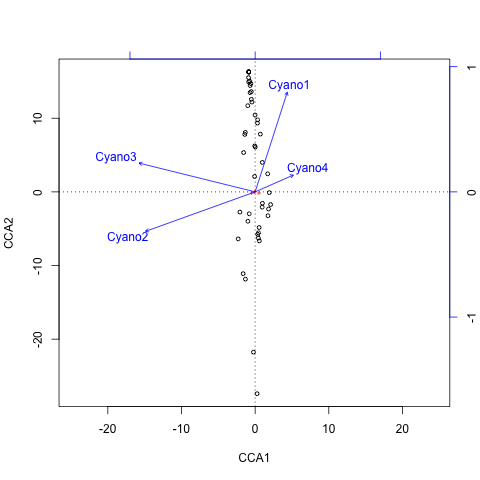

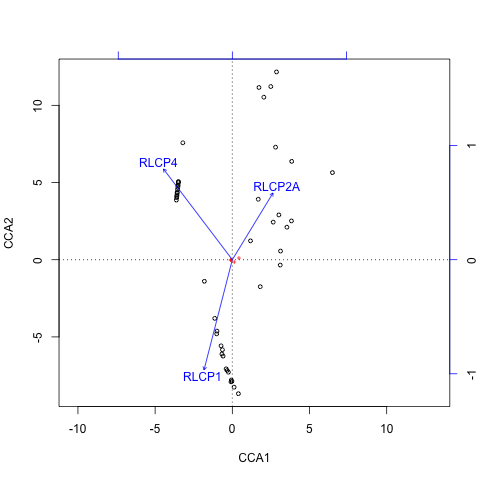

In [14]:
%%R
cyano<-decostand(cyphage.cca.prep[,c("logbin1.cyanos","logbin2.cyanos","logbin3.cyanos","logbin4.cyanos")], method="chi.square")
colnames(cyano)<-c("Cyano1","Cyano2","Cyano3","Cyano4")
cyphage.cca.cyano<-cca(ad.logcyphagenz~Cyano1+Cyano2+Cyano3+Cyano4, cyano, na.action=na.omit)
cyphage.cca.cyano
ordiplot(cyphage.cca.cyano)
anova(cyphage.cca.cyano)
anova(cyphage.cca.cyano, by="term", step=200)
ordiplot(cyano.cca4)

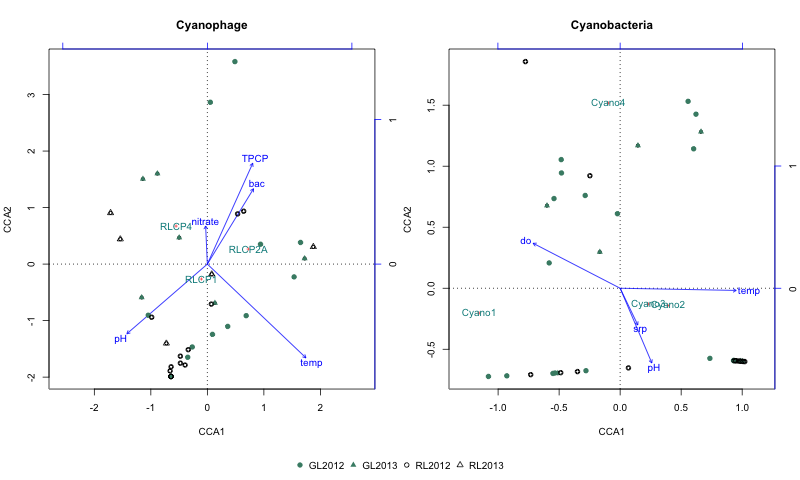

In [17]:
%%R -w 800
layout(matrix(c(1,2,3,3),2,2,byrow=TRUE), heights=c(15,1))
ordiplot(cyphage.cca.ordistep1)
with(cyphage.cca.prep1, points(cyphage.cca.ordistep,display="wa",col=lycol[lake.year],pch=lypch[lake.year]))
with(cyphage.cca.prep1, text(cyphage.cca.ordistep,display="sp",col="darkcyan"))
title(main="Cyanophage")
ordiplot(cyano.cca.ordistep, scaling=scl)
with(cyano.cca.prep, points(cyano.cca.ordistep,display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=scl))
with(cyano.cca.prep, text(cyano.cca.ordistep,display="sp",col="darkcyan", scaling=scl))
title(main="Cyanobacteria")
par(mar=c(0, 0, 0, 0))
plot.new()
with(cyano.cca.prep, legend('center','groups',legend=levels(lake.year),pch=lypch, bty="n", col=lycol, ncol=4))       

Error in dev.off() : cannot shut down device 1 (the null device)


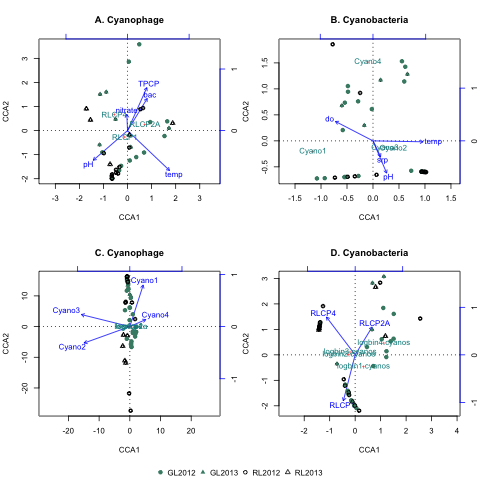

In [19]:
%%R
layout(matrix(c(1,2,3,4,5,5),3,2,byrow=TRUE), heights=c(15,15,1))
ordiplot(cyphage.cca.ordistep1)
with(cyphage.cca.prep1, points(cyphage.cca.ordistep,display="wa",col=lycol[lake.year],pch=lypch[lake.year]))
with(cyphage.cca.prep1, text(cyphage.cca.ordistep,display="sp",col="darkcyan"))
title(main="A. Cyanophage")
ordiplot(cyano.cca.ordistep, scaling=scl)
with(cyano.cca.prep, points(cyano.cca.ordistep,display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=scl))
with(cyano.cca.prep, text(cyano.cca.ordistep,display="sp",col="darkcyan", scaling=scl))
title(main="B. Cyanobacteria")
ordiplot(cyphage.cca.cyano)
with(cyphage.cca.prep1, points(cyphage.cca.cyano,display="wa",col=lycol[lake.year],pch=lypch[lake.year]))
with(cyphage.cca.prep1, text(cyphage.cca.cyano,display="sp",col="darkcyan"))
title(main="C. Cyanophage")
ordiplot(cyano.cca4, scaling=scl)
with(cyano.cca.prep, points(cyano.cca4,display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=scl))
with(cyano.cca.prep, text(cyano.cca4,display="sp",col="darkcyan", scaling=scl))
title(main="D. Cyanobacteria")
par(mar=c(0, 0, 0, 0))
plot.new()
with(cyano.cca.prep, legend('center','groups',legend=levels(lake.year),pch=lypch, bty="n", col=lycol, ncol=4))       

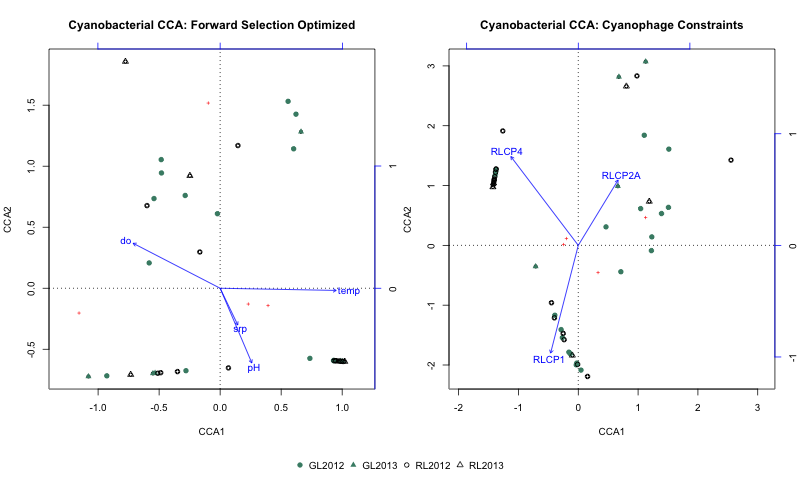

In [21]:
%%R -w 800
layout(matrix(c(1,2,3,3),2,2,byrow=TRUE), heights=c(15,1))
ordiplot(cyano.cca.ordistep, scaling=scl)
with(cyano.cca.prep1, points(cyano.cca.ordistep,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanobacterial CCA: Forward Selection Optimized")
ordiplot(cyano.cca4, scaling=scl)
with(cyano.cca.prep, points(cyano.cca4,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanobacterial CCA: Cyanophage Constraints")
par(mar=c(0, 0, 0, 0))
plot.new()
with(cyano.cca.prep, legend('center','groups',legend=levels(lake.year),pch=lypch, bty="n", col=lycol, ncol=4))       


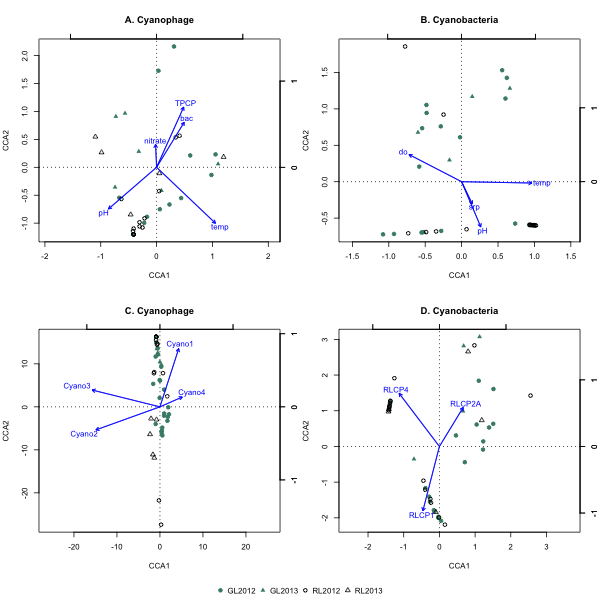

In [24]:
%%R -w 600 -h 600
layout(matrix(c(1,2,3,4,5,5),3,2,byrow=TRUE), heights=c(15,15,1))
with(cyphage.cca.prep1, plot(cyphage.cca.ordistep1,type="none",display=c("bp","wa"),col=lycol[lake.year],pch=lypch[lake.year], scaling=3))
with(cyphage.cca.prep1, points(cyphage.cca.ordistep,display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=3))
with(cyphage.cca.prep1, points(cyphage.cca.ordistep,display=c("bp"),col="blue", scaling=3))
with(cyphage.cca.prep1, text(cyphage.cca.ordistep,display=c("bp"),col="blue"))
#with(cyphage.cca.prep1, points(cyphage.cca.ordistep,display=c("lc"),col="grey", pch=lypch[lake.year]))
title(main="A. Cyanophage")

with(cyano.cca.prep, plot(cyano.cca.ordistep,type="none",display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=scl))
with(cyano.cca.prep, points(cyano.cca.ordistep,display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=scl))
with(cyano.cca.prep, points(cyano.cca.ordistep,display="bp",col="blue"))
with(cyano.cca.prep, text(cyano.cca.ordistep,display="bp",col="blue"))
#with(cyano.cca.prep, points(cyano.cca.ordistep,display="lc",col="grey", pch=lypch[lake.year]))
title(main="B. Cyanobacteria")

with(cyphage.cca.prep1, plot(cyphage.cca.cyano,type="none",display="wa",col=lycol[lake.year],pch=lypch[lake.year]))
with(cyphage.cca.prep1, points(cyphage.cca.cyano,display="wa",col=lycol[lake.year],pch=lypch[lake.year]))
with(cyphage.cca.prep1, text(cyphage.cca.cyano,display="bp",col="blue"))
with(cyphage.cca.prep1, points(cyphage.cca.cyano,display="bp",col="blue"))
title(main="C. Cyanophage")

with(cyano.cca.prep, plot(cyano.cca4,type="none",display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=scl))
with(cyano.cca.prep, points(cyano.cca4,display="wa",col=lycol[lake.year],pch=lypch[lake.year], scaling=scl))
with(cyano.cca.prep, points(cyano.cca4,display="bp",col="blue"))
with(cyano.cca.prep, text(cyano.cca4,display="bp",col="blue"))
title(main="D. Cyanobacteria")

par(mar=c(0, 0, 0, 0))
plot.new()
with(cyano.cca.prep, legend('center','groups',legend=levels(lake.year),pch=lypch, bty="n", col=lycol, ncol=4))    

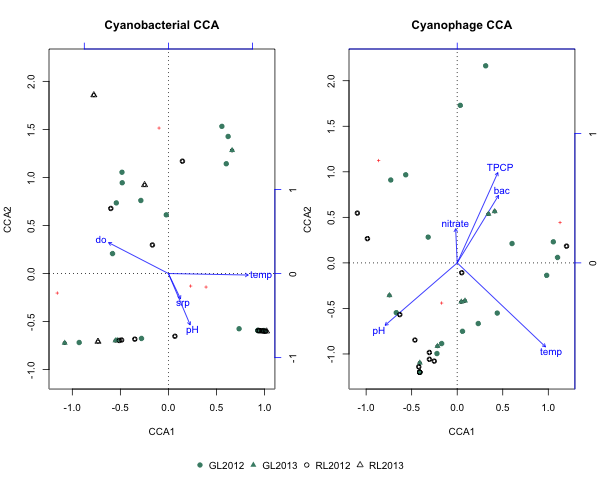

In [25]:
%%R -w 600
layout(matrix(c(1,2,3,3),2,2,byrow=TRUE), heights=c(15,1))
ordiplot(cyano.cca.ordistep, scaling=scl)
with(cyano.cca.prep1, points(cyano.cca.ordistep,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanobacterial CCA")
ordiplot(cyphage.cca.ordistep1, scaling=scl)
with(cyano.cca.prep, points(cyphage.cca.ordistep1,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanophage CCA")
par(mar=c(0, 0, 0, 0))
plot.new()
with(cyano.cca.prep, legend('center','groups',legend=levels(lake.year),pch=lypch, bty="n", col=lycol, ncol=4))       


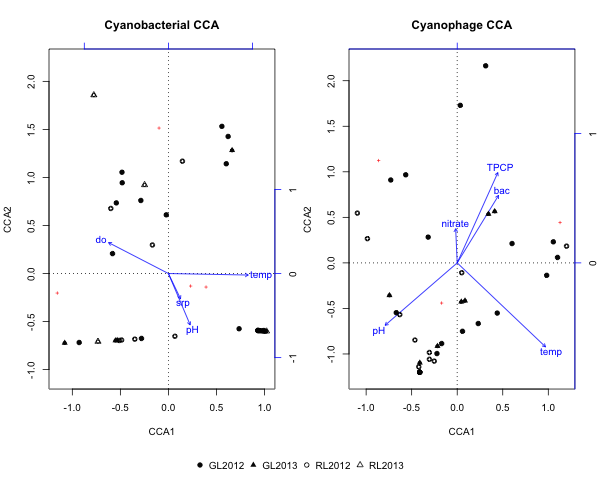

In [28]:
%%R -w 600

lypch=c(19,17,1,2)
lycol=c("grey2","grey2","black","black")
mcol=c("red","orange","green","blue","purple")
mcol2=c("firebrick4","darkorange4","forestgreen","navyblue","purple4")
mpch=c(17,19)
ycol=c("red","black")
scl=3

layout(matrix(c(1,2,3,3),2,2,byrow=TRUE), heights=c(15,1))
ordiplot(cyano.cca.ordistep, scaling=scl)
with(cyano.cca.prep1, points(cyano.cca.ordistep,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanobacterial CCA")
ordiplot(cyphage.cca.ordistep1, scaling=scl)
with(cyano.cca.prep, points(cyphage.cca.ordistep1,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanophage CCA")
par(mar=c(0, 0, 0, 0))
plot.new()
with(cyano.cca.prep, legend('center','groups',legend=levels(lake.year),pch=lypch, bty="n", col=lycol, ncol=4))       


In [ ]:
%%R
png("./new_plots/AB_CCA_Ordiplots.png",    # create PNG        
    width = 8*200,        # 5 x 300 pixels
    height = 5*200,
    res = 300,            # 300 pixels per inch
    pointsize = 12)

In [33]:
%%R
png("./new_plots/AB_CCA_Ordiplots.png",    # create PNG        
    width = 8*200,        # 5 x 300 pixels
    height = 5*200,
    res = 300,            # 300 pixels per inch
    pointsize = 10)


layout(matrix(c(1,2,3,3),2,2,byrow=TRUE), heights=c(15,1))
ordiplot(cyano.cca.ordistep, scaling=scl)
with(cyano.cca.prep1, points(cyano.cca.ordistep,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanobacteria")
title(main="A", adj = 0)

ordiplot(cyphage.cca.ordistep1, scaling=scl)
with(cyano.cca.prep, points(cyphage.cca.ordistep1,display="wa",col=lycol[lake.year],scaling=scl,pch=lypch[lake.year]))
title(main="Cyanophage")
title(main="B", adj = 0)
par(mar=c(0, 0, 0, 0))
plot.new()
with(cyano.cca.prep, legend('center','groups',legend=levels(lake.year),pch=lypch, bty="n", col=lycol, ncol=4))       

dev.off()

quartz_off_screen 
                2 


In [32]:
!open ./new_plots/AB_CCA_Ordiplots.png -a Preview